# Case Study 1 : Yelp Data Analysis

**Required Readings:** 
* [Yelp Dataset Challenge](https://www.yelp.com/dataset_challenge) 
* Please download the Yelp dataset from the above webpage.

**NOTE**
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.


Here is an example of the data format. More details are included [here](https://www.yelp.com/dataset_challenge)

## Business Objects

Business objects contain basic information about local businesses. The fields are as follows:

```json
{
  'type': 'business',
  'business_id': (a unique identifier for this business),
  'name': (the full business name),
  'neighborhoods': (a list of neighborhood names, might be empty),
  'full_address': (localized address),
  'city': (city),
  'state': (state),
  'latitude': (latitude),
  'longitude': (longitude),
  'stars': (star rating, rounded to half-stars),
  'review_count': (review count),
  'photo_url': (photo url),
  'categories': [(localized category names)]
  'open': (is the business still open for business?),
  'schools': (nearby universities),
  'url': (yelp url)
}
```
## Checkin Objects
```json
{
    'type': 'checkin',
    'business_id': (encrypted business id),
    'checkin_info': {
        '0-0': (number of checkins from 00:00 to 01:00 on all Sundays),
        '1-0': (number of checkins from 01:00 to 02:00 on all Sundays),
        ...
        '14-4': (number of checkins from 14:00 to 15:00 on all Thursdays),
        ...
        '23-6': (number of checkins from 23:00 to 00:00 on all Saturdays)
    }, # if there was no checkin for a hour-day block it will not be in the dict
}
```

# Problem: pick a data science problem that you plan to solve using Yelp Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using yelp data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

In [1]:
import os
import json
import numpy as np
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from itertools import product
import gc
from ast import literal_eval

tqdm.pandas()
pd.set_option("display.max_rows", 10000)

In [2]:
# drop features with NaN more than
NA_DROP_THRESHOLD = 0.9
# fill NaN with
NA_TOKEN = 'Missing'
# only consider objects that with more than # reviews
N_REV = 10

# Data Collection/Processing: 

## Processing

### load the datasets, do some basic preprocessing

In [3]:
#----------------------------------------------
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary

def process(yelp_dir):
    
    # load files
    print('loading reviews')
    with open(os.path.join(yelp_dir, 'review.json'), 'r', encoding='utf-8') as f:
        df_rev = pd.read_json(f, lines=True, )
        
    # process rev
    print('processing review')
    df_rev.drop(columns=['text', 'date'], inplace=True)
    
    
    # load files
    print('loading business')
    with open(os.path.join(yelp_dir, 'business.json'), 'r', encoding='utf-8') as f:
        df_bus = pd.read_json(f, lines=True)
    print('loading checkin')
    with open(os.path.join(yelp_dir, 'checkin.json'), 'r', encoding='utf-8') as f:
        df_chk = pd.read_json(f, lines=True)
    
    # process business
    print('processing business')
    
    # build new df to storage multivalue attrs
    print('building catogories df')
    df_bus['categories'] = df_bus['categories'].apply(lambda x: [item.strip() for item in x.split(',')] if x else None)
    cat_tmp = {'business_id': [],
               'category': []}
    def insert_into_cat(row):
        if row['categories']:
            business_id = row['business_id']
            cats = row['categories']
            for cat in cats:
                cat_tmp['business_id'].append(business_id)
                cat_tmp['category'].append(cat)

    df_bus.progress_apply(insert_into_cat, axis=1)
    df_bus_cat = pd.DataFrame(cat_tmp)
    df_bus.drop(columns=['categories'], inplace=True)
    
    
    print('building attributes df')
    # build attr lists
    attrs = []
    def attrs_union(x, attrs):
        if x:
            attrs = attrs.extend(list(x.keys()))
    df_bus['attributes'].apply(attrs_union, attrs=attrs)
    attrs = list(set(attrs))
    
    # build df
    attrs_tmp = {'business_id': []}
    for attr in attrs:
        attrs_tmp[attr] = []
    def insert_into_attr(row):
        if row['attributes']:
            attrs_tmp['business_id'].append(row['business_id'])
            this_attrs = row['attributes']
            for attr in attrs:
                attrs_tmp[attr].append(this_attrs.get(attr))
                
    df_bus.progress_apply(insert_into_attr, axis=1)
    df_bus_attr = pd.DataFrame(attrs_tmp)
    df_bus.drop(columns=['attributes'], inplace=True)
    
    ############ ATTN: STILL HAVE DICT IN df_bus_attr ############
    
    # process checkin
    print('processing checkin')
    
    df_chk['date'] = df_chk['date'].apply(lambda x: x.split(','))
    
    # rebuild df_chk
    print('rebuilding df_chk')
    chk_tmp = {'business_id': [],
               'date': []}
    def insert_into_chk(row):
        for date in row['date']:
            chk_tmp['business_id'].append(row['business_id'])
            chk_tmp['date'].append(date)

    df_chk.progress_apply(insert_into_chk, axis=1)
    df_chk = pd.DataFrame(chk_tmp)
    df_chk['date'] = df_chk['date'].astype('datetime64')
    
    
    # build hours df
    print('building hours df')
    hours_keys = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] # checked is indeed all the possible keys
    status = ['open', 'close']
    hour_tmp = {'business_id':[]}
    hours_attr = []
    for wk, st in product(hours_keys, status):
        this_attr = wk + '_' + st
        hours_attr.append(this_attr)
        hour_tmp[this_attr] = []

    def insert_into_hours(row):
        if row['hours']:
            hour_tmp['business_id'].append(row['business_id'])
            for wk in hours_keys:
                wk_hours = row['hours'].get(wk)
                if wk_hours:
                    open_time, close_time = [item.strip() for item in wk_hours.split('-')]
                else:
                    open_time, close_time = None, None
                hour_tmp[wk + '_open'].append(open_time)
                hour_tmp[wk + '_close'].append(open_time)

    df_bus.progress_apply(insert_into_hours, axis=1)
    df_bus_hours = pd.DataFrame(hour_tmp)
    df_bus.drop(columns=['hours'], inplace=True)
    
    
    print('finished')
    return df_bus, df_chk, df_bus_cat, df_bus_attr, df_bus_hours, df_rev

def load(yelp_dir, dfs):
    ret = []
    for df in dfs:
        if not df.endswith('.csv'):
            df = df + '.csv'
        path = os.path.join(yelp_dir, df)
        ret.append(pd.read_csv(path))
    return ret

#df_bus, df_chk, df_bus_cat, df_bus_attr, df_bus_hours, df_rev = process('J:/fastjupyter/yelp_dataset')
df_bus, df_bus_cat, df_bus_attr, df_rev, df_chk = load('data/case1/', ['bus', 'bus_cat', 'bus_attr', 'rev', 'chk'])


/home/wpishare/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (7,27) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### function to save the processed df

In [4]:
def save_df(df, name, index=False, **kwargs):
    df.to_csv(os.path.join('data/case1/', name), index=index, **kwargs)
#save_df(df_bus, 'bus.csv')
#save_df(df_chk, 'chk.csv')
#save_df(df_bus_cat, 'bus_cat.csv')
#save_df(df_bus_attr, 'bus_attr.csv')
#save_df(df_bus_hours, 'bus_hours.csv')
#save_df(df_rev, 'rev.csv')
# .applymap(literal_eval)

## Business

### get the business_id of all restaurants

We only want every restaurant, so we get the business_id of them, and intersect the tables in the below process.

In [5]:
res_id = df_bus_cat[df_bus_cat['category']=='Restaurants']['business_id']

### process the attributes with multivalues (dictonary-like)

In [6]:
def pro(x):
    if isinstance(x, str):
        if x.startswith('u"') or x.startswith("u'"):
            return literal_eval(x)
        elif x == 'none':
            return None
        elif x.startswith("'") and x.endswith("'"):
            return literal_eval(x)
        else:
            return x
    else:
        return x

In [7]:
df_bus_rest = df_bus.merge(res_id, on='business_id').applymap(pro)

In [8]:
df_bus_cat_rest = df_bus_cat.merge(res_id, on='business_id').applymap(pro)

In [9]:
pd.unique(df_bus_cat_rest['category'])

array(['Specialty Food', 'Restaurants', 'Dim Sum', 'Imported Food',
       'Food', 'Chinese', 'Ethnic Food', 'Seafood', 'Sushi Bars',
       'Japanese', 'Breakfast & Brunch', 'Mexican', 'Tacos', 'Tex-Mex',
       'Fast Food', 'Italian', 'Pizza', 'Chicken Wings', 'Sandwiches',
       'Salad', 'Burgers', 'Comfort Food', 'Patisserie/Cake Shop', 'Bars',
       'Nightlife', 'Juice Bars & Smoothies', 'Vegan', 'Tapas Bars',
       'Southern', 'Coffee & Tea', 'American (Traditional)',
       'American (New)', 'Steakhouses', 'Modern European', 'Wine Bars',
       'Hookah Bars', 'Persian/Iranian', 'Country Dance Halls',
       'Middle Eastern', 'Beer', 'Wine & Spirits', 'Lounges', 'Delis',
       'Fish & Chips', 'Polish', 'Korean', 'Ice Cream & Frozen Yogurt',
       'Desserts', 'Custom Cakes', 'Bakeries', 'Cafes', 'Canadian (New)',
       'Portuguese', 'Landmarks & Historical Buildings', 'Mediterranean',
       'Public Services & Government', 'Grocery', 'Butcher', 'Pubs',
       'Beer Gardens',

In [10]:
df_res_attr_rest = df_bus_attr.merge(res_id, on='business_id').applymap(pro)

In [11]:
def process_attrs(df_res_attr_rest=df_res_attr_rest):
    df_res_attr_rest_expand = df_res_attr_rest.copy()
    
    dic_cols = {'Ambience':[], 
                'BusinessParking': [], 
                'GoodForMeal': [],
                'BestNights': [],
                'Music': [], 
                'DietaryRestrictions': []}

    def insert_dic_cols(x):
        if x and not pd.isna(x):
            dict_x = literal_eval(x)
            if dict_x and not pd.isna(dict_x):
                dic_cols[col].extend(list(dict(dict_x).keys()))
            return dict_x
        else:
            return None

    for col in dic_cols:
        df_res_attr_rest_expand[col + '_dict'] = df_res_attr_rest_expand[col].apply(insert_dic_cols)
        dic_cols[col] = list(set(dic_cols[col]))
    df_res_attr_rest_expand.drop(columns=list(dic_cols.keys()), inplace=True)

    def add_new_att(x, subattr):
        if x and not pd.isna(x):
            return x.get(subattr)

    for col in dic_cols:
        for subattr in dic_cols[col]:
            attr_name = col + '_' + subattr
            df_res_attr_rest_expand[attr_name] = df_res_attr_rest_expand[col + '_dict'].apply(add_new_att, subattr=subattr)
        df_res_attr_rest_expand.drop(columns=[col + '_dict'], inplace=True)
    return df_res_attr_rest_expand.applymap(pro)

df_res_attr_rest_expand = process_attrs()

In [12]:
df_res_attr_rest_expand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57161 entries, 0 to 57160
Data columns (total 75 columns):
business_id                        57161 non-null object
ByAppointmentOnly                  643 non-null object
AgesAllowed                        33 non-null object
HappyHour                          3810 non-null object
RestaurantsPriceRange2             52091 non-null object
HairSpecializesIn                  5 non-null object
GoodForKids                        50661 non-null object
Open24Hours                        7 non-null object
OutdoorSeating                     48322 non-null object
BusinessAcceptsBitcoin             3369 non-null object
Alcohol                            23469 non-null object
RestaurantsGoodForGroups           50963 non-null object
RestaurantsReservations            50411 non-null object
BikeParking                        38886 non-null object
RestaurantsDelivery                49812 non-null object
BYOBCorkage                        1421 non-null ob

In [13]:
df_res_attr_rest_expand.nunique()

business_id                        57161
ByAppointmentOnly                      3
AgesAllowed                            4
HappyHour                              5
RestaurantsPriceRange2                 5
HairSpecializesIn                      5
GoodForKids                            3
Open24Hours                            2
OutdoorSeating                         3
BusinessAcceptsBitcoin                 4
Alcohol                                4
RestaurantsGoodForGroups               3
RestaurantsReservations                3
BikeParking                            3
RestaurantsDelivery                    3
BYOBCorkage                            4
Corkage                                2
BusinessAcceptsCreditCards             3
RestaurantsAttire                      4
HasTV                                  3
CoatCheck                              5
RestaurantsTakeOut                     3
BYOB                                   2
DogsAllowed                            3
DriveThru       

### select the businesses that have more than N_REV reviews

In [14]:
count = (df_rev.groupby('business_id', as_index=False)
                .agg({'stars': 'count'})
                .rename(columns={'stars': 'count'}))
count_ids = count[count['count'] > N_REV]['business_id']
df_bus_rest = df_bus_rest.merge(count_ids, on='business_id')
df_bus_cat_rest = df_bus_cat_rest.merge(count_ids, on='business_id')
df_res_attr_rest = df_res_attr_rest.merge(count_ids, on='business_id')
df_res_attr_rest_expand = df_res_attr_rest_expand.merge(count_ids, on='business_id')

In [15]:
df_res_attr_rest_expand.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39762 entries, 0 to 39761
Data columns (total 75 columns):
business_id                        39762 non-null object
ByAppointmentOnly                  558 non-null object
AgesAllowed                        29 non-null object
HappyHour                          3486 non-null object
RestaurantsPriceRange2             38898 non-null object
HairSpecializesIn                  2 non-null object
GoodForKids                        37878 non-null object
Open24Hours                        7 non-null object
OutdoorSeating                     37529 non-null object
BusinessAcceptsBitcoin             3010 non-null object
Alcohol                            19886 non-null object
RestaurantsGoodForGroups           38051 non-null object
RestaurantsReservations            37768 non-null object
BikeParking                        32978 non-null object
RestaurantsDelivery                37642 non-null object
BYOBCorkage                        1281 non-null ob

In [16]:
df_res_attr_rest_expand.nunique()

business_id                        39762
ByAppointmentOnly                      3
AgesAllowed                            4
HappyHour                              5
RestaurantsPriceRange2                 5
HairSpecializesIn                      2
GoodForKids                            3
Open24Hours                            2
OutdoorSeating                         3
BusinessAcceptsBitcoin                 4
Alcohol                                4
RestaurantsGoodForGroups               3
RestaurantsReservations                3
BikeParking                            3
RestaurantsDelivery                    3
BYOBCorkage                            4
Corkage                                2
BusinessAcceptsCreditCards             3
RestaurantsAttire                      4
HasTV                                  3
CoatCheck                              5
RestaurantsTakeOut                     3
BYOB                                   2
DogsAllowed                            3
DriveThru       

Notice that there are some attributes that only have 1 unique value. Find them out:

In [17]:
df_res_attr_rest_expand.nunique()[(df_res_attr_rest_expand.nunique() == 1)].index.to_list()

['Music_no_music',
 'DietaryRestrictions_kosher',
 'DietaryRestrictions_soy-free']

### process nulls, delete the attrs with too many nulls or with only 1 unique value

In [18]:
def nulls():
    n_instances = df_res_attr_rest_expand.shape[0]
    drop_cols = []
    for col in df_res_attr_rest_expand.columns[1:]:
        n_na = df_res_attr_rest_expand[col].isnull().sum()
        if (n_na / n_instances) > NA_DROP_THRESHOLD:
            drop_cols.append(col)
    df_res_attr_rest_expand_drop = df_res_attr_rest_expand.drop(columns=drop_cols).fillna(NA_TOKEN)
    
    one_unique = df_res_attr_rest_expand_drop.nunique()[(df_res_attr_rest_expand_drop.nunique() == 1)].index.to_list()
    df_res_attr_rest_expand_drop.drop(columns=one_unique, inplace=True)
    
    print('dropped cols are:\n%s' % (drop_cols + one_unique))
    
    return df_res_attr_rest_expand_drop
df_res_attr_rest_expand_drop = nulls()

dropped cols are:
['ByAppointmentOnly', 'AgesAllowed', 'HappyHour', 'HairSpecializesIn', 'Open24Hours', 'BusinessAcceptsBitcoin', 'BYOBCorkage', 'Corkage', 'CoatCheck', 'BYOB', 'DogsAllowed', 'DriveThru', 'RestaurantsCounterService', 'Smoking', 'AcceptsInsurance', 'GoodForDancing', 'BestNights_monday', 'BestNights_sunday', 'BestNights_thursday', 'BestNights_saturday', 'BestNights_tuesday', 'BestNights_wednesday', 'BestNights_friday', 'Music_background_music', 'Music_no_music', 'Music_dj', 'Music_live', 'Music_video', 'Music_karaoke', 'Music_jukebox', 'DietaryRestrictions_vegan', 'DietaryRestrictions_dairy-free', 'DietaryRestrictions_vegetarian', 'DietaryRestrictions_kosher', 'DietaryRestrictions_halal', 'DietaryRestrictions_gluten-free', 'DietaryRestrictions_soy-free']


### To categorical, forming X and Y

In [19]:
for col in df_res_attr_rest_expand_drop.columns[1:]:
    df_res_attr_rest_expand_drop[col] = df_res_attr_rest_expand_drop[col].astype('category')

In [20]:
df_res_attr_rest_expand_drop.head()

,business_id,RestaurantsPriceRange2,GoodForKids,OutdoorSeating,Alcohol,RestaurantsGoodForGroups,RestaurantsReservations,BikeParking,RestaurantsDelivery,BusinessAcceptsCreditCards,...,BusinessParking_valet,BusinessParking_street,BusinessParking_lot,BusinessParking_validated,GoodForMeal_breakfast,GoodForMeal_dessert,GoodForMeal_lunch,GoodForMeal_latenight,GoodForMeal_brunch,GoodForMeal_dinner
0,QXAEGFB4oINsVuTFxEYKFQ,2,True,False,full_bar,True,True,False,False,Missing,...,False,False,True,False,False,False,True,False,False,True
1,gnKjwL_1w79qoiV3IC_xQQ,2,True,False,beer_and_wine,True,True,True,False,True,...,False,False,True,False,False,False,True,False,False,True
2,1Dfx3zM-rW4n-31KeC8sJg,1,True,False,Missing,True,False,Missing,False,True,...,False,False,False,False,Missing,Missing,Missing,Missing,Missing,Missing
3,fweCYi8FmbJXHCqLnwuk8w,2,True,False,Missing,True,False,True,True,True,...,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing
4,PZ-LZzSlhSe9utkQYU8pFg,2,True,False,full_bar,True,True,Missing,False,True,...,False,False,True,False,Missing,Missing,Missing,Missing,Missing,Missing


In [21]:
X = df_res_attr_rest_expand_drop.set_index('business_id')

In [22]:
Y = pd.merge(df_bus_rest[['business_id', 'stars']], df_res_attr_rest_expand_drop['business_id'], on='business_id').set_index('business_id')

In [23]:
save_df(X, 'X.csv', index=True)
save_df(Y, 'Y.csv', index=True)

## functions to load X and Y

In [24]:
def load_XY():
    X = pd.read_csv('data/case1/X.csv', index_col='business_id')
    Y = pd.read_csv('data/case1/Y.csv', index_col='business_id')
    return X, Y

In [25]:
X, Y = load_XY()

In [26]:
X.head()

,RestaurantsPriceRange2,GoodForKids,OutdoorSeating,Alcohol,RestaurantsGoodForGroups,RestaurantsReservations,BikeParking,RestaurantsDelivery,BusinessAcceptsCreditCards,RestaurantsAttire,...,BusinessParking_valet,BusinessParking_street,BusinessParking_lot,BusinessParking_validated,GoodForMeal_breakfast,GoodForMeal_dessert,GoodForMeal_lunch,GoodForMeal_latenight,GoodForMeal_brunch,GoodForMeal_dinner
business_id,,,,,,,,,,,,,,,,,,,,,
QXAEGFB4oINsVuTFxEYKFQ,2,True,False,full_bar,True,True,False,False,Missing,casual,...,False,False,True,False,False,False,True,False,False,True
gnKjwL_1w79qoiV3IC_xQQ,2,True,False,beer_and_wine,True,True,True,False,True,casual,...,False,False,True,False,False,False,True,False,False,True
1Dfx3zM-rW4n-31KeC8sJg,1,True,False,Missing,True,False,Missing,False,True,casual,...,False,False,False,False,Missing,Missing,Missing,Missing,Missing,Missing
fweCYi8FmbJXHCqLnwuk8w,2,True,False,Missing,True,False,True,True,True,casual,...,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing
PZ-LZzSlhSe9utkQYU8pFg,2,True,False,full_bar,True,True,Missing,False,True,casual,...,False,False,True,False,Missing,Missing,Missing,Missing,Missing,Missing


In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39762 entries, QXAEGFB4oINsVuTFxEYKFQ to p1eUTUB_5hf1enoKYBV3DA
Data columns (total 37 columns):
RestaurantsPriceRange2        39762 non-null object
GoodForKids                   39762 non-null object
OutdoorSeating                39762 non-null object
Alcohol                       39762 non-null object
RestaurantsGoodForGroups      39762 non-null object
RestaurantsReservations       39762 non-null object
BikeParking                   39762 non-null object
RestaurantsDelivery           39762 non-null object
BusinessAcceptsCreditCards    39762 non-null object
RestaurantsAttire             39762 non-null object
HasTV                         39762 non-null object
RestaurantsTakeOut            39762 non-null object
WiFi                          39762 non-null object
NoiseLevel                    39762 non-null object
Caters                        39762 non-null object
RestaurantsTableService       39762 non-null object
WheelchairAccessible      

In [28]:
X.nunique()

RestaurantsPriceRange2        6
GoodForKids                   4
OutdoorSeating                4
Alcohol                       4
RestaurantsGoodForGroups      4
RestaurantsReservations       4
BikeParking                   4
RestaurantsDelivery           4
BusinessAcceptsCreditCards    4
RestaurantsAttire             5
HasTV                         4
RestaurantsTakeOut            4
WiFi                          5
NoiseLevel                    6
Caters                        4
RestaurantsTableService       4
WheelchairAccessible          4
Ambience_classy               3
Ambience_trendy               3
Ambience_romantic             3
Ambience_touristy             3
Ambience_hipster              3
Ambience_intimate             3
Ambience_upscale              3
Ambience_casual               3
Ambience_divey                3
BusinessParking_garage        3
BusinessParking_valet         3
BusinessParking_street        3
BusinessParking_lot           3
BusinessParking_validated     3
GoodForM

In [29]:
Y.head()

,stars
business_id,
QXAEGFB4oINsVuTFxEYKFQ,2.5
gnKjwL_1w79qoiV3IC_xQQ,4.0
1Dfx3zM-rW4n-31KeC8sJg,3.0
fweCYi8FmbJXHCqLnwuk8w,4.0
PZ-LZzSlhSe9utkQYU8pFg,4.0


# Data Exploration: Exploring the Yelp Dataset

**(1) Finding the most popular business categories:** 
* print the top 10 most popular business categories in the dataset and their counts (i.e., how many business objects in each category). Here we say a category is "popular" if there are many business objects in this category (such as 'restaurants').

In [30]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary


(df_bus_cat.groupby('category',as_index=False)
           .count()
           .rename(columns={'business_id':'count'})
           .sort_values(by='count', ascending=False)[:10])












,category,count
1004,Restaurants,59371
1057,Shopping,31878
462,Food,29989
579,Home Services,19729
116,Beauty & Spas,19370
546,Health & Medical,17171
706,Local Services,13932
84,Automotive,13203
803,Nightlife,13095
104,Bars,11341


** (2) Find the most popular business objects** 
* print the top 10 most popular business objects in the dataset and their counts (i.e., how many checkins in total for each business object).  Here we say a business object is "popular" if the business object attracts a large number of checkins from the users.

In [31]:
# Your code starts here
#   Please add comments or text cells in between to explain the general idea of each block of the code.
#   Please feel free to add more cells below this cell if necessary


(df_chk.groupby('business_id')
       .count()
       .rename(columns={'date':'count'})
       .sort_values(by='count', ascending=False)[:10]
       .merge(df_bus, on='business_id', how='inner')[['name','count']])










,name,count
0,McCarran International Airport,143061
1,Phoenix Sky Harbor International Airport,123126
2,Charlotte Douglas International Airport,54787
3,The Cosmopolitan of Las Vegas,46384
4,Kung Fu Tea,38277
5,ARIA Resort & Casino,34353
6,The Venetian Las Vegas,32343
7,Bellagio Hotel,31185
8,Caesars Palace Las Vegas Hotel & Casino,30782
9,MGM Grand Hotel,30098


# The Solution: implement a data science solution to the problem you are trying to solve.

## Feature Engineering, XGB Regression and Feature Importance Ananlysis

Briefly describe the idea of your solution to the problem in the following cell:

Write codes to implement the solution in python:

### Load Data

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

In [33]:
X, Y = load_XY();

In [34]:
Data = X.merge(Y,left_index=True, right_index=True)
col_names = list(Data.columns)
col_names

['RestaurantsPriceRange2',
 'GoodForKids',
 'OutdoorSeating',
 'Alcohol',
 'RestaurantsGoodForGroups',
 'RestaurantsReservations',
 'BikeParking',
 'RestaurantsDelivery',
 'BusinessAcceptsCreditCards',
 'RestaurantsAttire',
 'HasTV',
 'RestaurantsTakeOut',
 'WiFi',
 'NoiseLevel',
 'Caters',
 'RestaurantsTableService',
 'WheelchairAccessible',
 'Ambience_classy',
 'Ambience_trendy',
 'Ambience_romantic',
 'Ambience_touristy',
 'Ambience_hipster',
 'Ambience_intimate',
 'Ambience_upscale',
 'Ambience_casual',
 'Ambience_divey',
 'BusinessParking_garage',
 'BusinessParking_valet',
 'BusinessParking_street',
 'BusinessParking_lot',
 'BusinessParking_validated',
 'GoodForMeal_breakfast',
 'GoodForMeal_dessert',
 'GoodForMeal_lunch',
 'GoodForMeal_latenight',
 'GoodForMeal_brunch',
 'GoodForMeal_dinner',
 'stars']

### Data Cleanning

In [35]:
for feature in col_names:
    Data[feature].replace("None",'Missing',inplace=True)

In [36]:
Data['Alcohol'].replace("u'beer_and_wine'","beer_and_wine",inplace=True)
Data['Alcohol'].replace("'beer_and_wine'","beer_and_wine",inplace=True)
Data['Alcohol'].replace("u'none'","none",inplace=True)
Data['Alcohol'].replace("'none'","none",inplace=True)
Data['Alcohol'].replace("u'full_bar'","full_bar",inplace=True)
Data['Alcohol'].replace("'full_bar'","full_bar",inplace=True)

Data['WiFi'].replace("u'no'","'no'",inplace=True)
Data['WiFi'].replace("u'free'","free",inplace=True)
Data['WiFi'].replace("u'paid'","paid",inplace=True)
Data['WiFi'].replace("'no'",'no',inplace=True)
Data['WiFi'].replace("'free'",'free',inplace=True)
Data['WiFi'].replace("'paid'",'paid',inplace=True)

Data['NoiseLevel'].replace("u'loud'","loud",inplace=True)
Data['NoiseLevel'].replace("u'quiet'","quiet",inplace=True)
Data['NoiseLevel'].replace("u'average'","average",inplace=True)
Data['NoiseLevel'].replace("u'very_loud'",'very_loud',inplace=True)
Data['NoiseLevel'].replace("'loud'","loud",inplace=True)
Data['NoiseLevel'].replace("'quiet'","quiet",inplace=True)
Data['NoiseLevel'].replace("'average'","average",inplace=True)
Data['NoiseLevel'].replace("'very_loud'",'very_loud',inplace=True)

Data['RestaurantsAttire'].replace("u'casual'","casual",inplace=True)
Data['RestaurantsAttire'].replace("'casual'","casual",inplace=True)
Data['RestaurantsAttire'].replace("u'dressy'","dressy",inplace=True)
Data['RestaurantsAttire'].replace("'dressy'","dressy",inplace=True)
Data['RestaurantsAttire'].replace("u'formal'","formal",inplace=True)
Data['RestaurantsAttire'].replace("'formal'","formal",inplace=True)

### Boxplot and feature selection

In [37]:
useful = []

Text(0.5, 0.98, '')

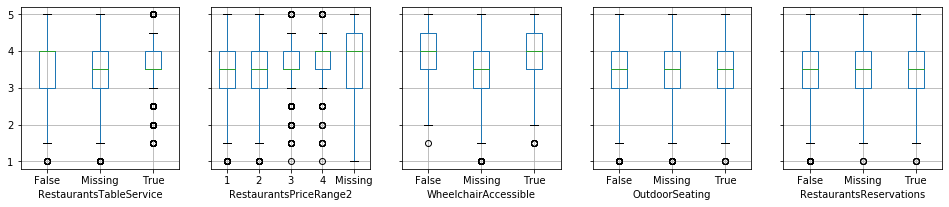

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=5,sharey=True,figsize=(16,3))
ax1 = Data.boxplot(column='stars', by='RestaurantsTableService',figsize=(3,3),ax=axes[0])
ax2 = Data.boxplot(column='stars', by='RestaurantsPriceRange2',figsize=(3,3),ax=axes[1])
ax3 = Data.boxplot(column='stars', by='WheelchairAccessible',figsize=(3,3), ax=axes[2])
ax4 = Data.boxplot(column='stars', by='OutdoorSeating',figsize=(3,3),ax=axes[3])
ax5 = Data.boxplot(column='stars', by='RestaurantsReservations',figsize=(3,3),ax=axes[4])

for ax in axes:
    ax.set_title('')
fig.suptitle('')

In [39]:
useful=useful+['RestaurantsTableService', 'RestaurantsPriceRange2' ]

<font color=red >'Alcohol' seems not of much use. (Problem: how to deal with this 'none', u'none' and None? which means there is no alcohol)</font>

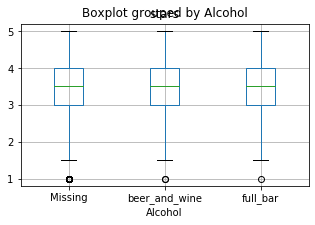

In [40]:
ax = Data.boxplot(column='stars', by='Alcohol',figsize=(5,3))

Text(0.5, 0.98, '')

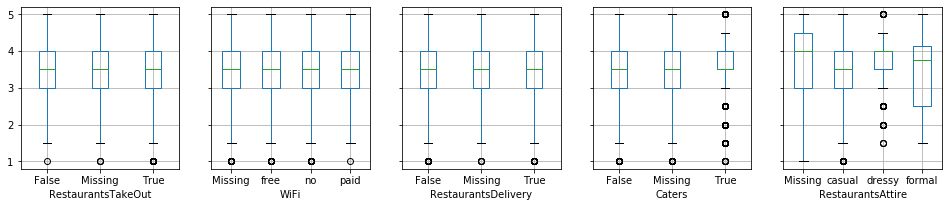

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=5,sharey=True,figsize=(16,3))
ax1 = Data.boxplot(column='stars', by='RestaurantsTakeOut',figsize=(2,3),ax=axes[0])
ax2 = Data.boxplot(column='stars', by='WiFi',figsize=(3,3),ax=axes[1])
ax3 = Data.boxplot(column='stars', by='RestaurantsDelivery',figsize=(3,3),ax=axes[2])
ax4 = Data.boxplot(column='stars', by='Caters',figsize=(3,3),ax=axes[3])
ax5 = Data.boxplot(column='stars', by='RestaurantsAttire',figsize=(3,3), ax=axes[4])
for ax in axes:
    ax.set_title('')
fig.suptitle('')

In [42]:
useful = useful + ['Caters', 'RestaurantsAttire']

<font color = green >'NoiseLevel' and 'BusinessAcceptsCreditCards' could be useful! </font>

Text(0.5, 0.98, '')

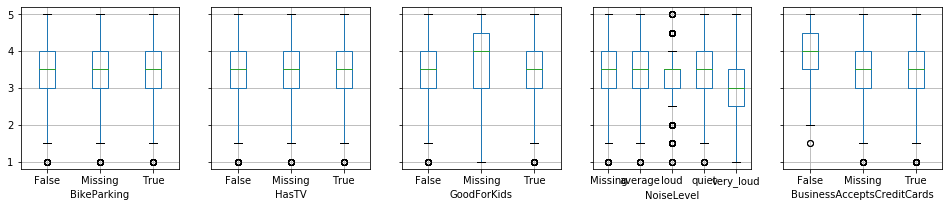

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=5,sharey=True,figsize=(16,3))
_col = ['BikeParking','HasTV','GoodForKids','NoiseLevel','BusinessAcceptsCreditCards']
for i in range(0,5):
    Data.boxplot(column='stars', by=_col[i],figsize=(4,3),ax=axes[i])
for ax in axes:
    ax.set_title('')
fig.suptitle('')

In [44]:
useful = useful+['NoiseLevel', 'BusinessAcceptsCreditCards']

<font color=green> 'BusinessParking_validated','BusinessParking_street','BusinessParking_valet' might be useful </font>

Text(0.5, 0.98, '')

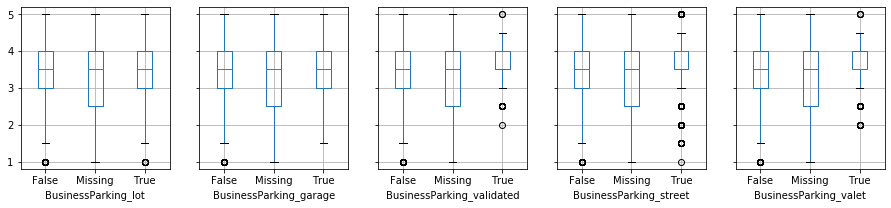

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=5,sharey=True,figsize=(15,3))
_col = ['BusinessParking_lot','BusinessParking_garage','BusinessParking_validated','BusinessParking_street','BusinessParking_valet']
for i in range(0,5):
    Data.boxplot(column='stars', by=_col[i],figsize=(4,3),ax=axes[i])
for ax in axes:
    ax.set_title('')
fig.suptitle('')


In [46]:
useful=useful+['BusinessParking_validated','BusinessParking_street','BusinessParking_valet']

<font color = green> 'Ambience_romantic','Ambience_intimate','Ambience_hipster','Ambience_touristy' might be of use </font>

Text(0.5, 0.98, '')

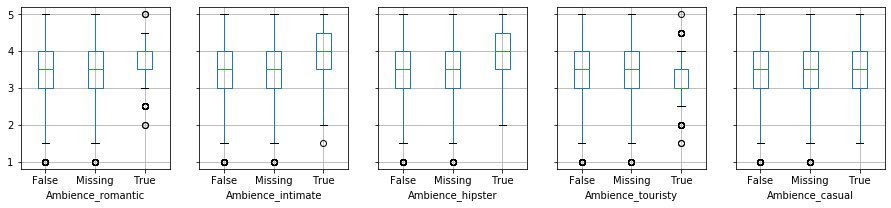

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=5,sharey=True,figsize=(15,3))
_col = ['Ambience_romantic','Ambience_intimate','Ambience_hipster','Ambience_touristy','Ambience_casual']
for i in range(0,5):
    Data.boxplot(column='stars', by=_col[i],figsize=(4,3),ax=axes[i])
for ax in axes:
    ax.set_title('')
fig.suptitle('')


In [48]:
useful = useful+['Ambience_romantic','Ambience_intimate','Ambience_hipster','Ambience_touristy']

<font color = green>'Ambience_upscale','Ambience_trendy', 'Ambience_classy' might be helpful </font>

Text(0.5, 0.98, '')

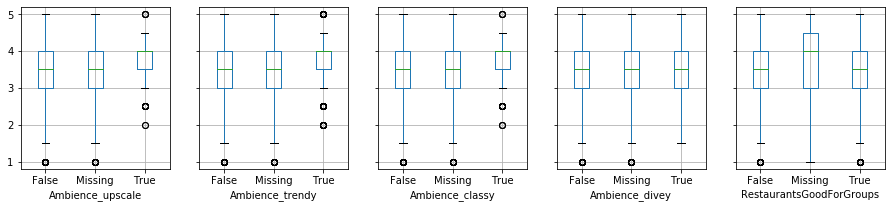

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=5,sharey=True,figsize=(15,3))
_col = ['Ambience_upscale','Ambience_trendy', 'Ambience_classy','Ambience_divey','RestaurantsGoodForGroups']
for i in range(0,5):
    Data.boxplot(column='stars', by=_col[i],figsize=(4,3),ax=axes[i])
for ax in axes:
    ax.set_title('')
fig.suptitle('')


In [50]:
useful = useful + ['Ambience_upscale','Ambience_trendy', 'Ambience_classy']

<font color = green>'GoodForMeal_brunch','GoodForMeal_dinner' might be helpful </font>

Text(0.5, 0.98, '')

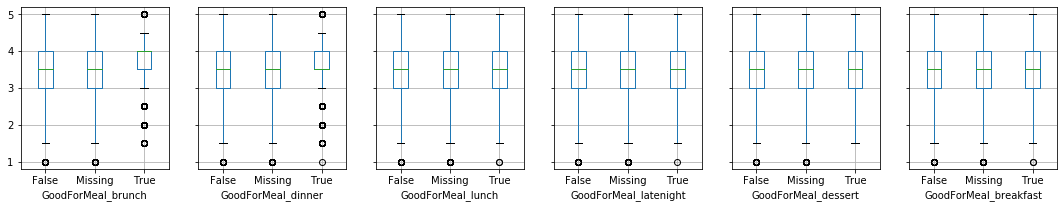

In [51]:
_col = ['GoodForMeal_brunch','GoodForMeal_dinner','GoodForMeal_lunch','GoodForMeal_latenight','GoodForMeal_dessert','GoodForMeal_breakfast']
fig, axes = plt.subplots(nrows=1, ncols=6,sharey=True,figsize=(18,3))
for i in range(0,6):
    Data.boxplot(column='stars', by=_col[i],figsize=(3,3),ax=axes[i])
for ax in axes:
    ax.set_title('')
fig.suptitle('')

In [52]:
useful = useful+['GoodForMeal_brunch','GoodForMeal_dinner']

In [53]:
def get_useful():
    return useful


In [54]:
Train_X = Data[useful]
Train_X.to_csv("Train_X.csv")

## XGB and feature importance

### Load Data

In [55]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

In [56]:
df = pd.read_csv("./VariaS/Train_X.csv")
df.set_index('business_id',inplace=True)
Y = pd.read_csv("./VariaS/Y.csv")
Y.set_index('business_id',inplace=True)

### Manually encode the (somewhat quantitative) features

In [57]:
X_train, X_test, y_train, y_test = train_test_split(df,Y,test_size=0.3, random_state=0)
X_Y_train = pd.merge(X_train,y_train,left_index=True, right_index=True)


In [58]:
features = list(X_Y_train.columns)

In [59]:
features

['RestaurantsTableService',
 'RestaurantsPriceRange2',
 'Caters',
 'RestaurantsAttire',
 'NoiseLevel',
 'BusinessAcceptsCreditCards',
 'BusinessParking_validated',
 'BusinessParking_street',
 'BusinessParking_valet',
 'Ambience_romantic',
 'Ambience_intimate',
 'Ambience_hipster',
 'Ambience_touristy',
 'Ambience_upscale',
 'Ambience_trendy',
 'Ambience_classy',
 'GoodForMeal_brunch',
 'GoodForMeal_dinner',
 'stars']

In [60]:
for col in features:
    gb = X_Y_train.groupby([col])['stars'].mean()
    gb.rename(col,inplace=True).to_frame()
    X_Y_train.join(gb.rename(col,inplace=True).to_frame(), how='left',on=col,rsuffix='_mean_enc')


In [61]:
gb = X_Y_train.groupby(['RestaurantsTableService'])['stars'].mean()
gb.rename('RestaurantsTableService',inplace=True)
# X_Y_train.join(gb.to_frame(), how='left',on=col,rsuffix='_mean_enc')
# X_Y_train.head()
gb

RestaurantsTableService
False      3.628324
Missing    3.402753
True       3.681329
Name: RestaurantsTableService, dtype: float64

In [62]:
X_Y_train.head()

,RestaurantsTableService,RestaurantsPriceRange2,Caters,RestaurantsAttire,NoiseLevel,BusinessAcceptsCreditCards,BusinessParking_validated,BusinessParking_street,BusinessParking_valet,Ambience_romantic,Ambience_intimate,Ambience_hipster,Ambience_touristy,Ambience_upscale,Ambience_trendy,Ambience_classy,GoodForMeal_brunch,GoodForMeal_dinner,stars
business_id,,,,,,,,,,,,,,,,,,,
RWYQMss0RzbtDGGwRI3iaQ,Missing,3,Missing,casual,average,Missing,False,True,False,False,False,Missing,False,False,False,False,Missing,Missing,2.5
_5Se2W5k_WJuee-aqBpNPA,True,2,False,casual,loud,True,False,False,False,False,False,False,False,False,False,False,True,False,4.0
aGAeYVf2sBygo2OJJBbuIg,True,2,True,casual,loud,True,False,True,True,False,False,False,False,False,True,False,False,False,3.0
AbPQf-X7awuPFDULiJ43bg,Missing,1,False,casual,average,True,False,False,False,False,False,False,False,False,False,False,False,True,4.0
Yecau5RHd7hjMlsZFBccFQ,Missing,1,Missing,casual,quiet,True,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,False,False,2.0


In [63]:
df_encoded = df.replace("True",1)
df_encoded = df_encoded.replace("False",0)

df_encoded['NoiseLevel'].replace("quiet",0,inplace=True)
df_encoded['NoiseLevel'].replace("average",1,inplace=True)
df_encoded['NoiseLevel'].replace("loud",2,inplace=True)
df_encoded['NoiseLevel'].replace("very_loud",3,inplace=True)
df_encoded.replace("casual",0,inplace=True)
df_encoded.replace("dressy",1,inplace=True)
df_encoded.replace("formal",2,inplace=True)

df_encoded.head()
df_encoded.to_csv('X_encoded.csv')

In [64]:
features = list(df.columns)
features 

['RestaurantsTableService',
 'RestaurantsPriceRange2',
 'Caters',
 'RestaurantsAttire',
 'NoiseLevel',
 'BusinessAcceptsCreditCards',
 'BusinessParking_validated',
 'BusinessParking_street',
 'BusinessParking_valet',
 'Ambience_romantic',
 'Ambience_intimate',
 'Ambience_hipster',
 'Ambience_touristy',
 'Ambience_upscale',
 'Ambience_trendy',
 'Ambience_classy',
 'GoodForMeal_brunch',
 'GoodForMeal_dinner']

### Try with linear regression (Lasso)

In [65]:
X_lr = df_encoded.copy()
X_lr.reset_index(drop=True, inplace=True)
#Y.drop(labels='business_id', inplace=True, axis=1)

In [66]:
X_lr.replace("Missing", 0.5, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X_lr,Y,test_size=0.3, random_state=0)

In [67]:
X_train.head()

,RestaurantsTableService,RestaurantsPriceRange2,Caters,RestaurantsAttire,NoiseLevel,BusinessAcceptsCreditCards,BusinessParking_validated,BusinessParking_street,BusinessParking_valet,Ambience_romantic,Ambience_intimate,Ambience_hipster,Ambience_touristy,Ambience_upscale,Ambience_trendy,Ambience_classy,GoodForMeal_brunch,GoodForMeal_dinner
20169,0.5,3,0.5,0.0,1.0,0.5,0.0,1.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.5
32730,1.0,2,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8510,1.0,2,1.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
36943,0.5,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
17929,0.5,1,0.5,0.0,0.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0


In [68]:
lr = Lasso(alpha=0, random_state=0)
lr.fit(X_train, y_train)
print(lr.coef_)

[ 0.1084645  -0.00203564  0.22382167  0.26201356 -0.16667238 -0.09609864
 -0.43231148  0.18931041 -0.04041047 -0.06018081  0.12862358  0.23247988
 -0.52142792 -0.10240355  0.25738445  0.11572098 -0.10738112  0.11369751]


/home/wpishare/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  
/home/wpishare/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/home/wpishare/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6369.464863996605, tolerance: 1.4104366309776157
  positive)


In [69]:
print(lr.coef_)
print(lr.intercept_)  

[ 0.1084645  -0.00203564  0.22382167  0.26201356 -0.16667238 -0.09609864
 -0.43231148  0.18931041 -0.04041047 -0.06018081  0.12862358  0.23247988
 -0.52142792 -0.10240355  0.25738445  0.11572098 -0.10738112  0.11369751]
[3.44719193]


In [70]:
lr.score(X_test,y_test)

0.09743711871442662

In [71]:
y_predict = lr.predict(X_test)

In [72]:
rmse_test = np.sqrt(mean_squared_error(y_predict,y_test))
rmse_test

0.6777239237305865

In [73]:
lr.score(X_train,y_train)

0.09680949514452775

In [74]:
train = pd.merge(X_train, y_train,left_index=True, right_index=True)
train.to_csv("train.csv")

### Try with XGB

#### XGBRegressor with default gamma

In [75]:
X_xgb_train = X_train.replace(0.5,np.nan)
X_xgb_test = X_test.replace(0.5,np.nan)

X_xgb_train['RestaurantsPriceRange2'] = X_xgb_train['RestaurantsPriceRange2'].apply(lambda x: float(x))
xgb_reg = XGBRegressor(n_estimators=100,max_depth=5,gamma=0, missing=np.nan) 
xgb_reg.fit(X_train,y_train)

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields RestaurantsPriceRange2

In [76]:
X_xgb_train.dtypes

RestaurantsTableService       float64
RestaurantsPriceRange2        float64
Caters                        float64
RestaurantsAttire             float64
NoiseLevel                    float64
BusinessAcceptsCreditCards    float64
BusinessParking_validated     float64
BusinessParking_street        float64
BusinessParking_valet         float64
Ambience_romantic             float64
Ambience_intimate             float64
Ambience_hipster              float64
Ambience_touristy             float64
Ambience_upscale              float64
Ambience_trendy               float64
Ambience_classy               float64
GoodForMeal_brunch            float64
GoodForMeal_dinner            float64
dtype: object

<font color=red> Something wrong with the RestaurantsPriceRange2 column dtype. Try XGB without it</font>

In [77]:
x_xgb_drop_price = X_xgb_train.drop(labels='RestaurantsPriceRange2',axis=1)
xgb_reg = XGBRegressor(n_estimators=100,max_depth=5,gamma=0, missing=np.nan) 
xgb_reg.fit(x_xgb_drop_price,y_train)

[20:38:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [78]:
x_test_drop_price = X_xgb_test.drop(labels='RestaurantsPriceRange2',axis=1)
y_pred_drop_price= xgb_reg.predict(x_test_drop_price)

In [79]:
xgb_rmse_test = np.sqrt(mean_squared_error(y_pred_drop_price,y_test))
rmse_test

0.6777239237305865

# Results: summarize and visualize the results discovered from the analysis

## Feature Importance

In [80]:
model_df = pd.DataFrame({'columns':list(x_xgb_drop_price.columns)[0:], 'values':xgb_reg.feature_importances_})
model_df 

,columns,values
0,RestaurantsTableService,0.121343
1,Caters,0.087839
2,RestaurantsAttire,0.078825
3,NoiseLevel,0.070538
4,BusinessAcceptsCreditCards,0.056088
5,BusinessParking_validated,0.043773
6,BusinessParking_street,0.116993
7,BusinessParking_valet,0.010829
8,Ambience_romantic,0.024360
9,Ambience_intimate,0.060685


## Plot feature importance

In [81]:
import matplotlib.pyplot as plt
model_df.sort_values(by='values',inplace=True)
model_df.rename(columns={'columns':'features','values':'importance'},inplace=True)


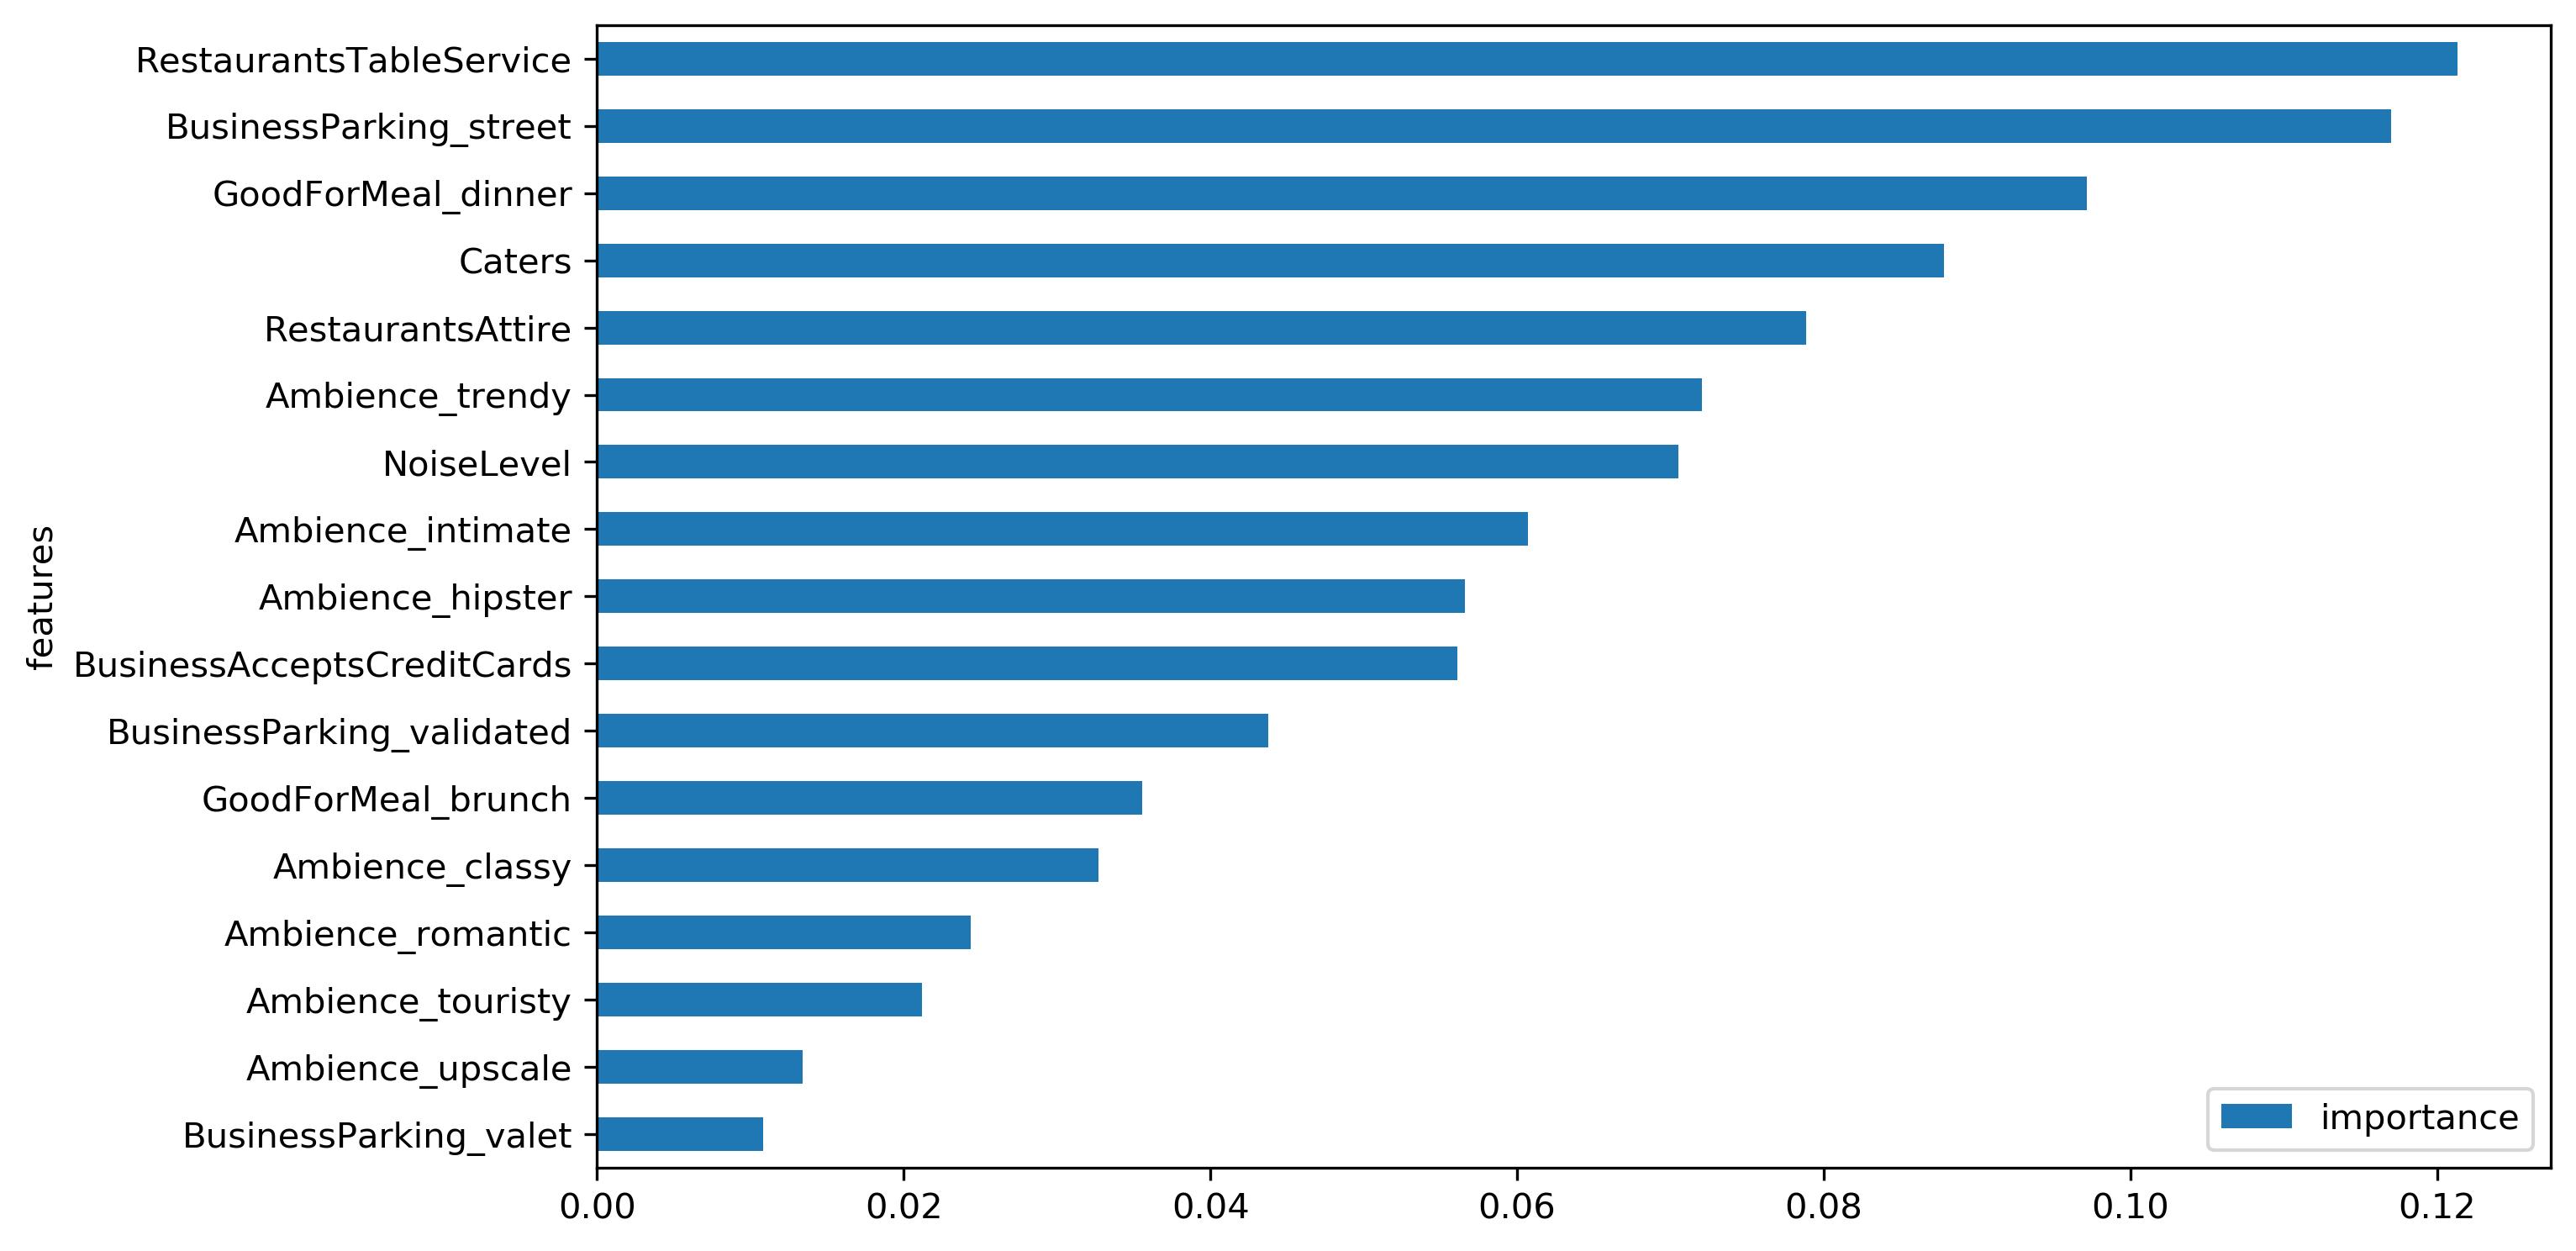

In [82]:
plt.figure(dpi=300)
model_df.plot.barh(x='features', y='importance', rot=0, figsize=(10,6),ax = plt.gca())

try different gamma=0, learning_rate=0.1, max_delta_step=0, objective="binary:logistic" or objective='reg:linear

*-----------------
# Done

All set! 

**What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 7 minutes' talk) to present about the case study . Each team present their case studies in class for 7 minutes.

Please compress all the files in a zipped file.


**How to submit:**

        Please submit through Canvas, in the Assignment "Case Study 1".
        
**Note: Each team only needs to submit one submission in Canvas**


# Peer-Review Grading Template:

**Total Points: (100 points)** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (10 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       2: I can barely understand what data they are trying to collect/process
       4: I can barely understand why the data is relevant to the problem
       6: the data are relevant to the problem, but better data can be collected
       8: the data collected are relevant and at a proper scale
      10: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the following task:
    
    (1) Finding the most popular business categories (5 points):
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect
    
    (2) Find the most popular business objects (5 points)
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect
    
    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        


